In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from utilities import preprocessing
from pyspark.sql import SparkSession
from pyspark.sql.types import StringType, ArrayType, FloatType, IntegerType
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import CountVectorizer
from pyspark.sql.functions import col, udf
from pyspark.ml.clustering import LDA

In [2]:
spark = SparkSession.builder \
           .appName('Tuning LDA Model') \
           .config("spark.jars", "mysql-connector-j-8.0.32.jar")\
           .config("spark.driver.memory", "6g") \
           .config("spark.executor.memory", "8g") \
           .getOrCreate()

In [3]:
data = spark.read \
            .format("jdbc") \
            .option("driver","com.mysql.cj.jdbc.Driver") \
            .option("url", "jdbc:mysql://web-database/Web") \
            .option("dbtable", "redditData") \
            .option("user", "root") \
            .option("password", "123") \
            .load() 
data.count()

394

In [4]:
data = data.select('id', 'category', 'descriptions')
data = data.dropna(subset = ('category'))

## For Business topic

In [5]:
business_data = data.filter(col('category') == 'Business')
business_data.count()

48

In [8]:
preprocessed_business_df = preprocessing(business_data, 'descriptions')

vectorizer = CountVectorizer().setInputCol("filtered").setOutputCol("features").fit(preprocessed_business_df)
wordVectors_business = vectorizer.transform(preprocessed_business_df)

In [10]:
wordVectors_business.show(5)

+---+--------+--------------------+--------------------+--------------------+--------------------+
| id|category|        descriptions|  descriptions_words|            filtered|            features|
+---+--------+--------------------+--------------------+--------------------+--------------------+
| 17|Business|Do companies unde...|[do, company, und...|[company, underst...|(330,[14,51,174,1...|
| 21|Business|Five cool project...|[five, cool, proj...|[five, cool, proj...|(330,[10,24,172,1...|
| 28|Business|Vice Media files ...|[vice, media, fil...|[vice, media, fil...|(330,[31,97,118,2...|
| 35|Business|Wells Fargo reach...|[well, fargo, rea...|[well, fargo, rea...|(330,[9,57,85,100...|
| 44|Business|Consumer debt pas...|[consumer, debt, ...|[consumer, debt, ...|(330,[3,63,73,93,...|
+---+--------+--------------------+--------------------+--------------------+--------------------+
only showing top 5 rows



In [13]:
models = []
log_likelihood = []
log_perplexity = []
for num in range(2, 11):
    lda = LDA(k = num, maxIter = 50, featuresCol = 'features', seed = 2)
    ldaModel = lda.fit(wordVectors_business)
    models.append(ldaModel)
    ll = ldaModel.logLikelihood(wordVectors_business)
    lp = ldaModel.logPerplexity(wordVectors_business)
    log_likelihood.append(ll)
    log_perplexity.append(lp)

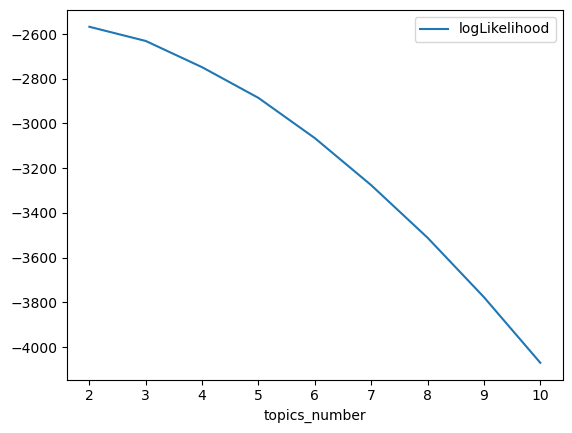

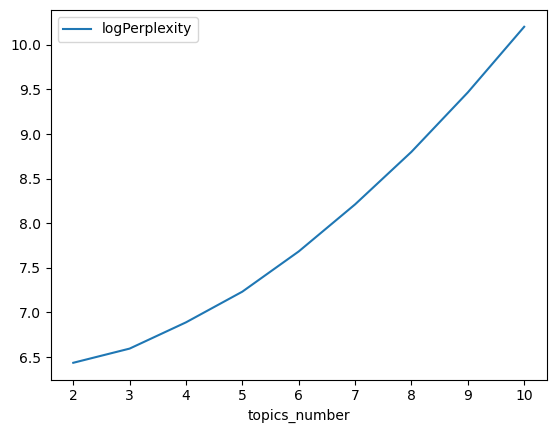

In [15]:
plot_data = pd.DataFrame(list(zip(range(2, 11), log_likelihood, log_perplexity)),
            columns = ['topics_number','logLikelihood','logPerplexity'])    

plot_data.plot(x = 'topics_number', y = 'logLikelihood',kind = 'line')
plt.show()

plot_data.plot(x = 'topics_number', y = 'logPerplexity',kind = 'line')
plt.show()

=> K = 3

In [69]:
lda = LDA(k = 3, maxIter = 50, featuresCol = 'features', seed = 2)
ldaModel = lda.fit(wordVectors_business)
final = ldaModel.transform(wordVectors_business)

In [70]:
vocabulary = vectorizer.vocabulary

topics = ldaModel.describeTopics().collect()

for topic in topics:
    topic_id = topic['topic']
    topic_words_indices = topic['termIndices']
    word_probabilities = topic['termWeights']
    
    topic_words = [vocabulary[idx] for idx in topic_words_indices]
    
    print(f"Topic ID: {topic_id}")
    print("Top Words:")
    for i in range(len(topic_words)):
        word = topic_words[i]
        probability = word_probabilities[i]
        print(f"{word}: {probability}")
    print()

Topic ID: 0
Top Words:
new: 0.011303257953996235
arab: 0.00927466810104649
warn: 0.008205665069926024
inflation: 0.008128324217070033
britain: 0.007993224310606417
option: 0.007989805267305255
export: 0.007934489002050545
meet: 0.007875601371496795
trilateral: 0.00787374403039366
australian: 0.007829161223525682

Topic ID: 1
Top Words:
russia: 0.01652327380241282
say: 0.015194982025883756
g: 0.015095312560425329
league: 0.011267303829825555
ukrainian: 0.011145237132602962
russian: 0.010961579888037207
indicate: 0.00819242094191899
military: 0.008070372898148779
summit: 0.008018236589695762
zelensky: 0.007962654534778103

Topic ID: 2
Top Words:
china: 0.01790731001633139
ukraine: 0.014114576035829588
evacuate: 0.010763987048008199
asian: 0.010669576547161596
south: 0.010652095647735468
screw: 0.010648850569032904
execute: 0.010612347519633941
kyiv: 0.010603452110848658
lead: 0.010595633784604184
may: 0.010524108921719596



In [ ]:
to_array = udf(lambda v: v.toArray().tolist(), ArrayType(FloatType()))
max_index = udf(lambda x: x.index(__builtin__.max(x)) if x is not None else None, IntegerType())
final = final.withColumn('topicDistribution', to_array(final['topicDistribution']))
final = final.withColumn('topic', max_index(final['topicDistribution']))

In [74]:
final.show(10)

+---+--------+--------------------+--------------------+--------------------+--------------------+--------------------+-----+
| id|category|        descriptions|  descriptions_words|            filtered|            features|   topicDistribution|topic|
+---+--------+--------------------+--------------------+--------------------+--------------------+--------------------+-----+
| 17|Business|Do companies unde...|[do, company, und...|[company, underst...|(330,[14,51,174,1...|[0.9620028, 0.020...|    0|
| 21|Business|Five cool project...|[five, cool, proj...|[five, cool, proj...|(330,[10,24,172,1...|[0.023097973, 0.0...|    2|
| 28|Business|Vice Media files ...|[vice, media, fil...|[vice, media, fil...|(330,[31,97,118,2...|[0.9147044, 0.045...|    0|
| 35|Business|Wells Fargo reach...|[well, fargo, rea...|[well, fargo, rea...|(330,[9,57,85,100...|[0.026277881, 0.0...|    2|
| 44|Business|Consumer debt pas...|[consumer, debt, ...|[consumer, debt, ...|(330,[3,63,73,93,...|[0.020527432, 0.0...

## For Sci/Tech topic

In [20]:
tech_data = data.filter(col('category') == 'Sci/Tech')
tech_data.count()

114

In [21]:
preprocessed_tech_df = preprocessing(tech_data, 'descriptions')

vectorizer = CountVectorizer().setInputCol("filtered").setOutputCol("features").fit(preprocessed_tech_df)
wordVectors_tech = vectorizer.transform(preprocessed_tech_df)

In [22]:
wordVectors_tech.show(5)

+---+--------+--------------------+--------------------+--------------------+--------------------+
| id|category|        descriptions|  descriptions_words|            filtered|            features|
+---+--------+--------------------+--------------------+--------------------+--------------------+
|  6|Sci/Tech|Why we need a "Ma...|[why, we, need, a...|[need, manhattan,...|(728,[128,235,410...|
|  7|Sci/Tech|Bird Buddy introd...|[bird, buddy, int...|[bird, buddy, int...|(728,[1,44,107,13...|
| 10|Sci/Tech|TikTok content cr...|[tiktok, content,...|[tiktok, content,...|(728,[4,7,12,16,1...|
| 11|Sci/Tech|NASA picks Blue O...|[nasa, pick, blue...|[nasa, pick, blue...|(728,[8,9,129,394...|
| 14|Sci/Tech|Italy earmarks $M...|[italy, earmark, ...|[italy, earmark, ...|(728,[1,64,65,114...|
+---+--------+--------------------+--------------------+--------------------+--------------------+
only showing top 5 rows



In [30]:
models = []
log_likelihood = []
log_perplexity = []
for num in range(2, 11):
    lda = LDA(k = num, maxIter = 50, featuresCol = 'features', seed = 2)
    ldaModel = lda.fit(wordVectors_tech)
    models.append(ldaModel)
    ll = ldaModel.logLikelihood(wordVectors_tech)
    lp = ldaModel.logPerplexity(wordVectors_tech)
    log_likelihood.append(ll)
    log_perplexity.append(lp)

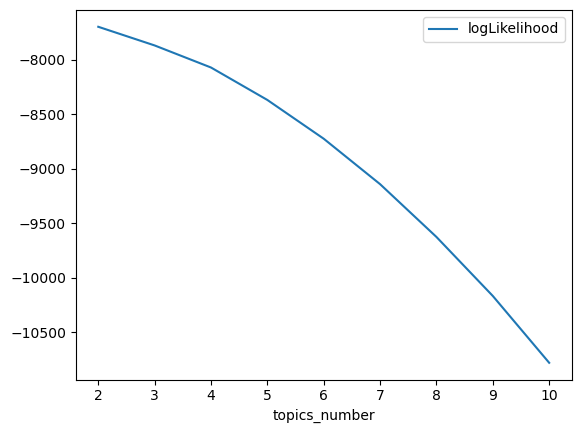

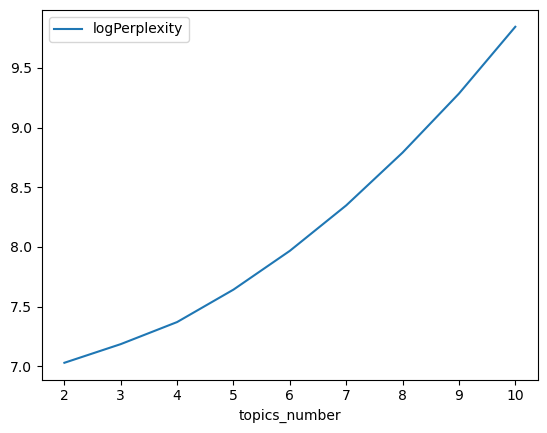

In [31]:
plot_data = pd.DataFrame(list(zip(range(2, 11), log_likelihood, log_perplexity)),
            columns = ['topics_number','logLikelihood','logPerplexity'])    

plot_data.plot(x = 'topics_number', y = 'logLikelihood',kind = 'line')
plt.show()

plot_data.plot(x = 'topics_number', y = 'logPerplexity',kind = 'line')
plt.show()

=> K = 4

In [32]:
lda = LDA(k = 4, maxIter = 50, featuresCol = 'features', seed = 2)
ldaModel = lda.fit(wordVectors_tech)

In [33]:
vocabulary = vectorizer.vocabulary

topics = ldaModel.describeTopics().collect()

for topic in topics:
    topic_id = topic['topic']
    topic_words_indices = topic['termIndices']
    word_probabilities = topic['termWeights']
    
    topic_words = [vocabulary[idx] for idx in topic_words_indices]
    
    print(f"Topic ID: {topic_id}")
    print("Top Words:")
    for i in range(len(topic_words)):
        word = topic_words[i]
        probability = word_probabilities[i]
        print(f"{word}: {probability}")
    print()

Topic ID: 0
Top Words:
ai: 0.021097084536331006
chatgpt: 0.011597711017403766
train: 0.009104043007464256
new: 0.00883116688327605
workers: 0.008087008540586927
internet: 0.007885179483998141
us: 0.0074080255517997564
help: 0.0072226627499281625
tech: 0.007194632539916181
push: 0.006296727603288351

Topic ID: 1
Top Words:
eu: 0.008861803484058638
take: 0.008240285130128923
tesla: 0.007054814821578806
second: 0.006725881159103139
neutrality: 0.006220153662213644
net: 0.006153327920575236
cultural: 0.006136632662145616
defend: 0.006122461341542174
amp: 0.006054693469407399
knowledge: 0.006034131135457445

Topic ID: 2
Top Words:
new: 0.012404466819234884
service: 0.009478655215208766
make: 0.008762271943347836
hours: 0.007785009174540885
renewable: 0.007636319365404119
solar: 0.007326803234173127
first: 0.006686770301406309
spain: 0.006084977700437616
car: 0.0058125630239916045
say: 0.005435225616115442

Topic ID: 3
Top Words:
say: 0.012797963796464123
ban: 0.012199153164066055
montana: 0

## For Sports topic

In [34]:
sports_data = data.filter(col('category') == 'Sports')
sports_data.count()

78

In [35]:
preprocessed_sports_df = preprocessing(sports_data, 'descriptions')

vectorizer = CountVectorizer().setInputCol("filtered").setOutputCol("features").fit(preprocessed_sports_df)
wordVectors_sports = vectorizer.transform(preprocessed_sports_df)

In [36]:
wordVectors_sports.show(5)

+---+--------+--------------------+--------------------+--------------------+--------------------+
| id|category|        descriptions|  descriptions_words|            filtered|            features|
+---+--------+--------------------+--------------------+--------------------+--------------------+
|  1|  Sports|Josh Harris group...|[josh, harris, gr...|[josh, harris, gr...|(536,[66,70,81,90...|
|  3|  Sports|France withdraw f...|[france, withdraw...|[france, withdraw...|(536,[2,5,10,56,7...|
| 13|  Sports|Everything for wr...|[everything, for,...|[everything, wres...|(536,[30,189,200,...|
| 18|  Sports|Russia, Belarus h...|[russia, belarus,...|[russia, belarus,...|(536,[14,95,191,2...|
| 25|  Sports|Florida Panthers ...|[florida, panther...|[florida, panther...|(536,[8,9,15,38,4...|
+---+--------+--------------------+--------------------+--------------------+--------------------+
only showing top 5 rows



In [37]:
models = []
log_likelihood = []
log_perplexity = []
for num in range(2, 11):
    lda = LDA(k = num, maxIter = 50, featuresCol = 'features', seed = 2)
    ldaModel = lda.fit(wordVectors_sports)
    models.append(ldaModel)
    ll = ldaModel.logLikelihood(wordVectors_sports)
    lp = ldaModel.logPerplexity(wordVectors_sports)
    log_likelihood.append(ll)
    log_perplexity.append(lp)

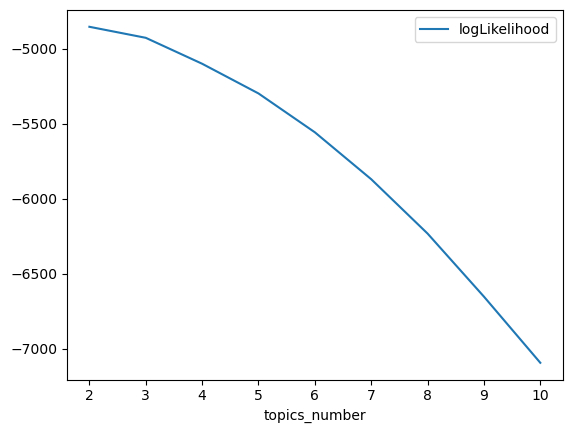

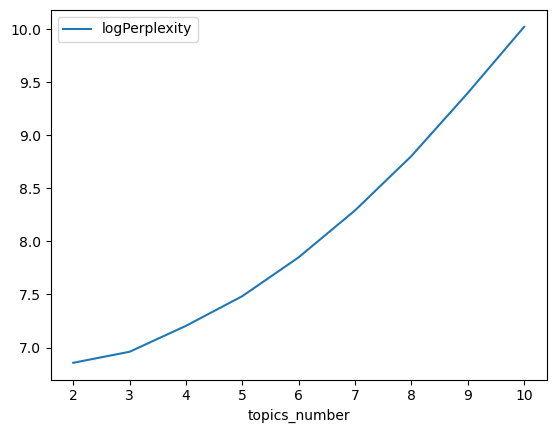

In [38]:
plot_data = pd.DataFrame(list(zip(range(2, 11), log_likelihood, log_perplexity)),
            columns = ['topics_number','logLikelihood','logPerplexity'])    

plot_data.plot(x = 'topics_number', y = 'logLikelihood',kind = 'line')
plt.show()

plot_data.plot(x = 'topics_number', y = 'logPerplexity',kind = 'line')
plt.show()

=> K = 3

In [39]:
lda = LDA(k = 3, maxIter = 50, featuresCol = 'features', seed = 2)
ldaModel = lda.fit(wordVectors_sports)

In [40]:
vocabulary = vectorizer.vocabulary

topics = ldaModel.describeTopics().collect()

for topic in topics:
    topic_id = topic['topic']
    topic_words_indices = topic['termIndices']
    word_probabilities = topic['termWeights']
    
    topic_words = [vocabulary[idx] for idx in topic_words_indices]
    
    print(f"Topic ID: {topic_id}")
    print("Top Words:")
    for i in range(len(topic_words)):
        word = topic_words[i]
        probability = word_probabilities[i]
        print(f"{word}: {probability}")
    print()

Topic ID: 0
Top Words:
win: 0.010274265644305726
hammon: 0.009760561809708246
wnba: 0.009719533680704268
ace: 0.009671919813092825
suspend: 0.008157683010536869
championship: 0.008026784061310074
sue: 0.007944378496949499
say: 0.007188681216769187
die: 0.0070711872201280595
favre: 0.006769136546571815

Topic ID: 1
Top Words:
league: 0.014527138983386067
rugby: 0.014436698318451369
world: 0.012660827114012707
open: 0.009470441475937223
french: 0.00940596543205341
final: 0.008432387476111343
return: 0.00798927736121402
kyrgios: 0.007225424783709335
miss: 0.007221944924391433
cup: 0.0062430555711712014

Topic ID: 2
Top Words:
suspend: 0.010768803927874498
soccer: 0.008364344009209615
ja: 0.007566528090663839
video: 0.007493434212170336
gun: 0.007492398159698419
morant: 0.007397240434473171
latest: 0.007371119557295385
nfl: 0.007218448212113151
leeds: 0.006377976467203858
todd: 0.005003612534325614



## For World topic

In [41]:
world_data = data.filter(col('category') == 'World')
world_data.count()

154

In [42]:
preprocessed_world_df = preprocessing(world_data, 'descriptions')

vectorizer = CountVectorizer().setInputCol("filtered").setOutputCol("features").fit(preprocessed_world_df)
wordVectors_world = vectorizer.transform(preprocessed_world_df)

In [43]:
wordVectors_world.show(5)

+---+--------+--------------------+--------------------+--------------------+--------------------+
| id|category|        descriptions|  descriptions_words|            filtered|            features|
+---+--------+--------------------+--------------------+--------------------+--------------------+
|  2|   World|China opposes G m...|[china, oppose, g...|[china, oppose, g...|(899,[1,4,27,113,...|
|  4|   World|Montreal group su...|[montreal, group,...|[montreal, group,...|(899,[25,46,85,90...|
|  5|   World|Assad shakes hand...|[assad, shake, ha...|[assad, shake, ha...|(899,[5,8,98,104,...|
|  8|   World|Data indicates fa...|[data, indicate, ...|[data, indicate, ...|(899,[45,143,155,...|
|  9|   World|Bionic technology...|[bionic, technolo...|[bionic, technolo...|(899,[66,69,104,1...|
+---+--------+--------------------+--------------------+--------------------+--------------------+
only showing top 5 rows



In [44]:
models = []
log_likelihood = []
log_perplexity = []
for num in range(2, 11):
    lda = LDA(k = num, maxIter = 50, featuresCol = 'features')
    ldaModel = lda.fit(wordVectors_world)
    models.append(ldaModel)
    ll = ldaModel.logLikelihood(wordVectors_world)
    lp = ldaModel.logPerplexity(wordVectors_world)
    log_likelihood.append(ll)
    log_perplexity.append(lp)

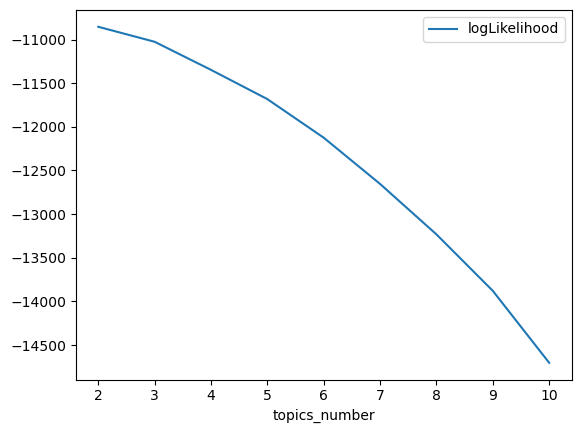

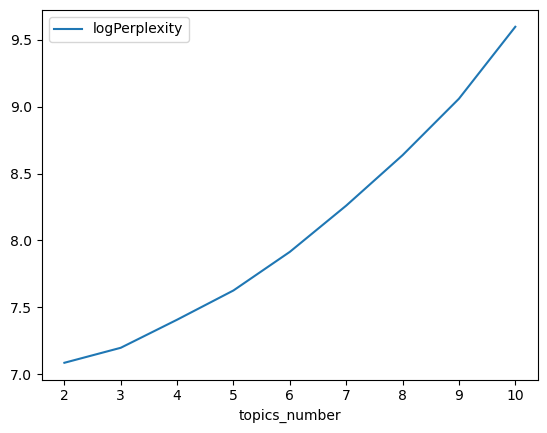

In [45]:
plot_data = pd.DataFrame(list(zip(range(2, 11), log_likelihood, log_perplexity)),
            columns = ['topics_number','logLikelihood','logPerplexity'])    

plot_data.plot(x = 'topics_number', y = 'logLikelihood',kind = 'line')
plt.show()

plot_data.plot(x = 'topics_number', y = 'logPerplexity',kind = 'line')
plt.show()

=> K = 3

In [46]:
lda = LDA(k = 3, maxIter = 50, featuresCol = 'features', seed = 2)
ldaModel = lda.fit(wordVectors_world)

In [47]:
vocabulary = vectorizer.vocabulary

topics = ldaModel.describeTopics().collect()

for topic in topics:
    topic_id = topic['topic']
    topic_words_indices = topic['termIndices']
    word_probabilities = topic['termWeights']
    
    topic_words = [vocabulary[idx] for idx in topic_words_indices]
    
    print(f"Topic ID: {topic_id}")
    print("Top Words:")
    for i in range(len(topic_words)):
        word = topic_words[i]
        probability = word_probabilities[i]
        print(f"{word}: {probability}")
    print()

Topic ID: 0
Top Words:
russia: 0.01808742548667861
g: 0.016959146963599455
ukraine: 0.014103980657196152
china: 0.012192564655444924
say: 0.009573660833453687
russian: 0.009057008900120194
summit: 0.008144655104866276
world: 0.007205498567883362
war: 0.006377475826713515
make: 0.006134909983480215

Topic ID: 1
Top Words:
group: 0.0074064191874399716
unitedstates: 0.0056118010335731265
say: 0.005539951961106283
people: 0.005385931160076447
italy: 0.005327077627727303
britain: 0.005304542633255762
plan: 0.005282920109328552
protest: 0.005018064229469517
india: 0.005001254602495619
billion: 0.004799753397432624

Topic ID: 2
Top Words:
arab: 0.013129784100485
syria: 0.009405249135161513
assad: 0.008283600605103547
league: 0.008119030168832767
get: 0.006231089844161868
summit: 0.005864657913475774
welcome: 0.005613812704615009
warm: 0.005532434925560468
earthquake: 0.005290324239984248
tsunami: 0.00522809911873164

